In [1]:
import pickle
import gc
import datetime
from math import floor, ceil
from time import perf_counter

import numpy as np  
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns;   sns.set_style("whitegrid")

import importlib
import CVA_Module ; importlib.reload(CVA_Module)

from numba import njit
from tqdm.notebook import trange, tqdm_notebook ; tqdm_notebook.pandas()

In [2]:
# Set general font size and Chart Dimentions
plt.rcParams["figure.autolayout"] = True 
plt.rcParams['font.size']       = '18'
CHART_DIMENTIONS_SINGLE_CHART   = (20,7) 
CHART_DIMENTIONS_DOUBLE_CHART   = (20,11) 
SAVE_CHARTS                     = False
PLOT_CHARTS                     = False

CVA = CVA_Module.CVA(CHART_DIMENTIONS_SINGLE_CHART=CHART_DIMENTIONS_SINGLE_CHART) # initialize CVA Object to be used

## Step 1: Load Forward Rates

In [3]:
# Simulation Parameters:
dt      = 1/52                           # 1/12 or 1/52 or 1/256
paths   = 5000                          # Use between 1_000 and 5_000
#spread = 10                             # SpreadIn bps
print(f'>>dt = {dt:.3f} or {dt*365:.2f}days')

>>dt = 0.019 or 7.02days


In [4]:
scenarios = pd.read_excel('data/rates/scenarios_description.xlsx', index_col=0)
swaps_set = pd.read_excel('data/swap_valuation/contracts.xlsx', index_col=0)

In [10]:
sofr3M = pd.read_excel('data/SOFR_Forward_Curve_26_04.xlsx')
date_of_sofr_load = datetime.date(2024, 5, 21) # 21_05_2024
sofr3M['timestamp'] = date_of_sofr_load
sofr3M_fb = sofr3M[['timestamp', 'tenor', 'fallback_rate']].copy()
sofr3M = sofr3M[['timestamp', 'tenor', 'rate']]
sofr3M_fb.columns = ['timestamp', 'tenor', 'rate']

In [11]:
sofr3M.set_index(['timestamp', 'tenor'], inplace=True)
sofr3M.sort_index(level=0, inplace=True)
sofr3M_fb.set_index(['timestamp', 'tenor'], inplace=True)
sofr3M_fb.sort_index(level=0, inplace=True)
df_SOFR3m_last = CVA.get_interpolated_interest_rates(sofr3M, frequency=dt)
df_SOFR3m_last = df_SOFR3m_last.dropna()
df_SOFR3m_FallBack = CVA.get_interpolated_interest_rates(sofr3M_fb, frequency=dt)
df_SOFR3m_FallBack = df_SOFR3m_FallBack.dropna()

In [12]:
#df_SOFR3m_last[df_SOFR3m_last.index <= swaps_set.loc["T"].max()]

In [13]:
# FUNDING SPREAD CURVE (FIXED SPREAD ASSUMPTION)
# median_fs = pd.read_excel('data/rates/libor_hist_rates.xlsx', index_col=0)
# fs = pd.DataFrame([median_fs.iloc[-1, -1]] * len(df_SOFR3m_last.index), index=df_SOFR3m_last.index, columns=['FS'])
# fs = fs.merge(pd.Series(np.exp(-fs['FS'] * fs.index), name='FS_DF'), how='left', left_index=True, right_index=True)
# fs.index.name = 't'
# fs = fs.reset_index()
# fs['FS_L1'] = fs['FS'].shift().fillna(0)
# fs['t_L1'] = fs['t'].shift().fillna(0)
# fs['FS_Fwd'] = np.exp(-fs['t_L1'] * fs['FS_L1']) - np.exp(-fs['t'] * fs['FS'])
# fs.to_excel("data/rates/funding_spread.xlsx")

In [14]:
fs_terms = df_SOFR3m_FallBack - df_SOFR3m_last
fs_terms.columns = ['FS']
fs_terms = fs_terms.merge(pd.Series(np.exp(-fs_terms['FS'] * fs_terms.index), name='FS_DF'), how='left', left_index=True, right_index=True)
fs_terms.index.name = 't'
fs_terms = fs_terms.reset_index()
fs_terms['FS_L1'] = fs_terms['FS'].shift().fillna(0)
fs_terms['t_L1'] = fs_terms['t'].shift().fillna(0)
fs_terms['FS_Fwd'] = np.exp(-fs_terms['t_L1'] * fs_terms['FS_L1']) - np.exp(-fs_terms['t'] * fs_terms['FS'])
fs_terms.to_excel("data/rates/funding_spread.xlsx")


## Step 2: Set forecasting properties

In [15]:
def simulate_rates(CVA, df_SOFR3m_last, df_SOFR3m_FallBack, scenarios, swaps_set, dt, paths):
    for scen in scenarios.columns:
        # Set simulation parameters:
        # Assumed Market Parameters:
        a       = scenarios.loc['mean_reversion', scen]  # speed of the mean-inversion # 0.01
        sigma   = scenarios.loc['sigma', scen]  # Volatility (from spot rates) for Hull-White Model # 0.01
        
        for swap_tenor in swaps_set.loc['T'].unique():
            # IRS Parameters:
            Fixed_rate                  = None             # When None the Fixed rate will equal the Swap Rate ; Set Fixed Rate when calculating CVA for existing IRS
            T                           = int(swap_tenor)  # End of Simulation and duration of Swap - max T = rates_df max T = 30Y
            fixed_payments_frequency    = 3/12      # Can only be 3/12
            floating_payments_frequency = 3/12      # Can be 3/12 or 6/12
            t_array = np.arange(start=0, stop=T+dt, step=dt)
            
            
            """ Step (2): Simulate Short Rates """
            # SOFR rates + spread
            intrabank_short_rate_3m_sofr     = CVA.get_short_rate_HW(T=T, a=a, sigma=sigma, dt=dt, paths=paths, rates_df=df_SOFR3m_FallBack) # df_eonia3m_lastIdx
            print(f'Intrabank short rate 3m: shape = {intrabank_short_rate_3m_sofr.shape}')

            # SOFR rates
            rfr_short_rate_3m_sofr     = CVA.get_short_rate_HW(T=T, a=a, sigma=sigma, dt=dt, paths=paths, rates_df=df_SOFR3m_last)
            print(f'rfr_short_rate_3m_sofr: shape = {rfr_short_rate_3m_sofr.shape}')
            
            
            #Получаем лист Дискаунт факторов
            rfr_fixed_P_t_T_list = []   ;   rfr_float_P_t_T_list = []   ;   print(f'Step (3.1): Calucate Discounted Factors for future fixed payments')
            for t in tqdm_notebook(t_array):
                rfr_P_t_T_array         = \
                    CVA.discount_factor_for_future_payments(df_SOFR3m_last, intrabank_short_rate_3m_sofr , t=t, T=T, payment_frequency=fixed_payments_frequency, 
                                                                dt=dt, alpha=a, sigma=sigma, return_t=False, _print=False)
                rfr_fixed_P_t_T_list.append(rfr_P_t_T_array)                                                  
                rfr_float_P_t_T_list.append(rfr_P_t_T_array)

            floating_P_t_T_list = []    ;   floating_tenors_list = []   ;   print(f'Step (3.2): Calucate Discounted Factors for future floating payments')
            for t in tqdm_notebook(t_array):
                _df_floating        =  df_SOFR3m_FallBack #df_eur3m_last # df_SOFR3m_last_spread
                _intrabank_short_r  =  intrabank_short_rate_3m_sofr #intrabank_short_rate_3m # intrabank_short_rate_3m_sofr #df_SOFR3m_last
                floating_P_t_T_array, floating_tenors_array    = \
                    CVA.discount_factor_for_future_payments(_df_floating, _intrabank_short_r , t=t, T=T, payment_frequency=floating_payments_frequency, 
                                                                dt=dt, alpha=a, sigma=sigma, return_t=True)                                  
                floating_P_t_T_list.append(floating_P_t_T_array)
                floating_tenors_list.append(floating_tenors_array)    

            """ Step (4): Calculate Forward Rate """
            forward_rate_curves_list = []   ;       print(f'>>Step (4): Calculate Forward Rate Curves for floating payments')
            for i in trange(len(floating_P_t_T_list)):
                forward_rate_curve_array = -np.log(floating_P_t_T_list[i]) / (floating_tenors_list[i] - t_array[i])
                forward_rate_curves_list.append(forward_rate_curve_array)    


            """ Step (5.1) : Find the Swap Rate at time t = 0, with given curves so the Value of the Swap = 0 """
            t_floating  = np.arange(start=floating_payments_frequency, stop=T+0.00001, step=floating_payments_frequency)
            t_fixed     = np.arange(start=fixed_payments_frequency, stop=T+0.00001, step=fixed_payments_frequency)        

            discount_factor_floating    = CVA.get_interpolated_interest_rates(sofr3M, frequency=floating_payments_frequency)
            discount_factor_floating    = (np.exp(-discount_factor_floating.iloc[:,0]*discount_factor_floating.index.values)).loc[t_floating]        

            discount_factor_fixed       = CVA.get_interpolated_interest_rates(sofr3M, frequency=fixed_payments_frequency)
            discount_factor_fixed       = (np.exp(-discount_factor_fixed.iloc[:,0]*discount_factor_fixed.index.values)).loc[t_fixed]

            forward_rates               = CVA.get_interpolated_interest_rates(sofr3M_fb, frequency=floating_payments_frequency)

            # SAVE RESULTS
            df_SOFR3m_last.to_excel(f'data/rates/{scen}/interpolated_forward_rates_{T}_{scen}.xlsx')
            df_SOFR3m_FallBack.to_excel(f'data/rates/{scen}/interpolated_forward_rates_fallback_{T}_{scen}.xlsx')
            # FILE DESCRIPTION
            # 521 period t - 10Y by dt = 1/52
            # 1000 number of simulations

            # Discount Factor For fixed rate leg - rfr_fixed_P_t_T_list
            with open(f'data/rates/{scen}/DF_fixed_leg_{T}_{scen}.pickle', 'wb') as f:
                pickle.dump(rfr_fixed_P_t_T_list, f)

            # Discount Factors for floating rate leg - rfr_float_P_t_T_list
            with open(f'data/rates/{scen}/DF_float_leg_{T}_{scen}.pickle', 'wb') as f:
                pickle.dump(rfr_float_P_t_T_list, f)

            # Forward Rate Curve for all future dates - forward_rate_curves_list
            with open(f'data/rates/{scen}/ForwardRateCurvesProjection_{T}_{scen}.pickle', 'wb') as f:
                pickle.dump(forward_rate_curves_list, f)
            
            
            if Fixed_rate: print(f'Fixed rate = {Fixed_rate*100:.4f}')
            swap_rate = np.sum(forward_rates.loc[t_floating].values[:,0] * floating_payments_frequency * discount_factor_floating.values) \
                 / np.sum(fixed_payments_frequency * discount_factor_fixed.values)
            print(f'Swap rate of Tenor {swap_tenor} = {swap_rate*100:.8f}%')
            
            swap_rate_inputs = {'discount_factor_floating': discount_factor_floating,
                               'discount_factor_fixed': discount_factor_fixed,
                               'forward_rates': forward_rates,
                               't_floating': t_floating,
                               't_floating': t_fixed,
                               'swap_rate_atm': swap_rate}
            
            # Calculated SWAP Rate for given Forward Rates
            with open(f'data/rates/{scen}/swap_rate_inputs_{T}_{scen}.pickle', 'wb') as f:
                pickle.dump(swap_rate_inputs, f)


In [16]:
simulate_rates(CVA, df_SOFR3m_last, df_SOFR3m_FallBack, scenarios, swaps_set, dt, paths) # df_SOFR3m_FallBack

Intrabank short rate 3m: shape = (5000, 261)
rfr_short_rate_3m_sofr: shape = (5000, 261)
Step (3.1): Calucate Discounted Factors for future fixed payments


  0%|          | 0/261 [00:00<?, ?it/s]

Step (3.2): Calucate Discounted Factors for future floating payments


  0%|          | 0/261 [00:00<?, ?it/s]

>>Step (4): Calculate Forward Rate Curves for floating payments


  0%|          | 0/261 [00:00<?, ?it/s]

Swap rate of Tenor 5 = 4.25943786%
Intrabank short rate 3m: shape = (5000, 157)
rfr_short_rate_3m_sofr: shape = (5000, 157)
Step (3.1): Calucate Discounted Factors for future fixed payments


  0%|          | 0/157 [00:00<?, ?it/s]

Step (3.2): Calucate Discounted Factors for future floating payments


  0%|          | 0/157 [00:00<?, ?it/s]

>>Step (4): Calculate Forward Rate Curves for floating payments


  0%|          | 0/157 [00:00<?, ?it/s]

Swap rate of Tenor 3 = 4.47949670%
Intrabank short rate 3m: shape = (5000, 261)
rfr_short_rate_3m_sofr: shape = (5000, 261)
Step (3.1): Calucate Discounted Factors for future fixed payments


  0%|          | 0/261 [00:00<?, ?it/s]

Step (3.2): Calucate Discounted Factors for future floating payments


  0%|          | 0/261 [00:00<?, ?it/s]

>>Step (4): Calculate Forward Rate Curves for floating payments


  0%|          | 0/261 [00:00<?, ?it/s]

Swap rate of Tenor 5 = 4.25943786%
Intrabank short rate 3m: shape = (5000, 157)
rfr_short_rate_3m_sofr: shape = (5000, 157)
Step (3.1): Calucate Discounted Factors for future fixed payments


  0%|          | 0/157 [00:00<?, ?it/s]

Step (3.2): Calucate Discounted Factors for future floating payments


  0%|          | 0/157 [00:00<?, ?it/s]

>>Step (4): Calculate Forward Rate Curves for floating payments


  0%|          | 0/157 [00:00<?, ?it/s]

Swap rate of Tenor 3 = 4.47949670%


In [20]:
plot_T = swaps_set.loc["T"].max()
plot_scen = 'Scenario 1'

# Discount Factor For fixed rate leg - rfr_fixed_P_t_T_list
with open(f'data/rates/{plot_scen}/DF_fixed_leg_{plot_T}_{plot_scen}.pickle', 'rb') as f:
    rfr_fixed_P_t_T_list = pickle.load(f)

# Discount Factors for floating rate leg - rfr_float_P_t_T_list
with open(f'data/rates/{plot_scen}/DF_float_leg_{plot_T}_{plot_scen}.pickle', 'rb') as f:
    rfr_float_P_t_T_list = pickle.load(f)

# Forward Rate Curve for all future dates - forward_rate_curves_list
with open(f'data/rates/{plot_scen}/ForwardRateCurvesProjection_{plot_T}_{plot_scen}.pickle', 'rb') as f:
    forward_rate_curves_list = pickle.load(f)

a = 0.01, sigma = 0.009974121444120737, r_0 = 0.0543, T = 5
intervals: 260 
Total Points: 1300000
paths: 5000 
dt:  0.019230769230769232
hw.shape=(5000, 261), g_t.shape=(261,), t.shape=(261,)

>>Time to simulate: 0.788sec



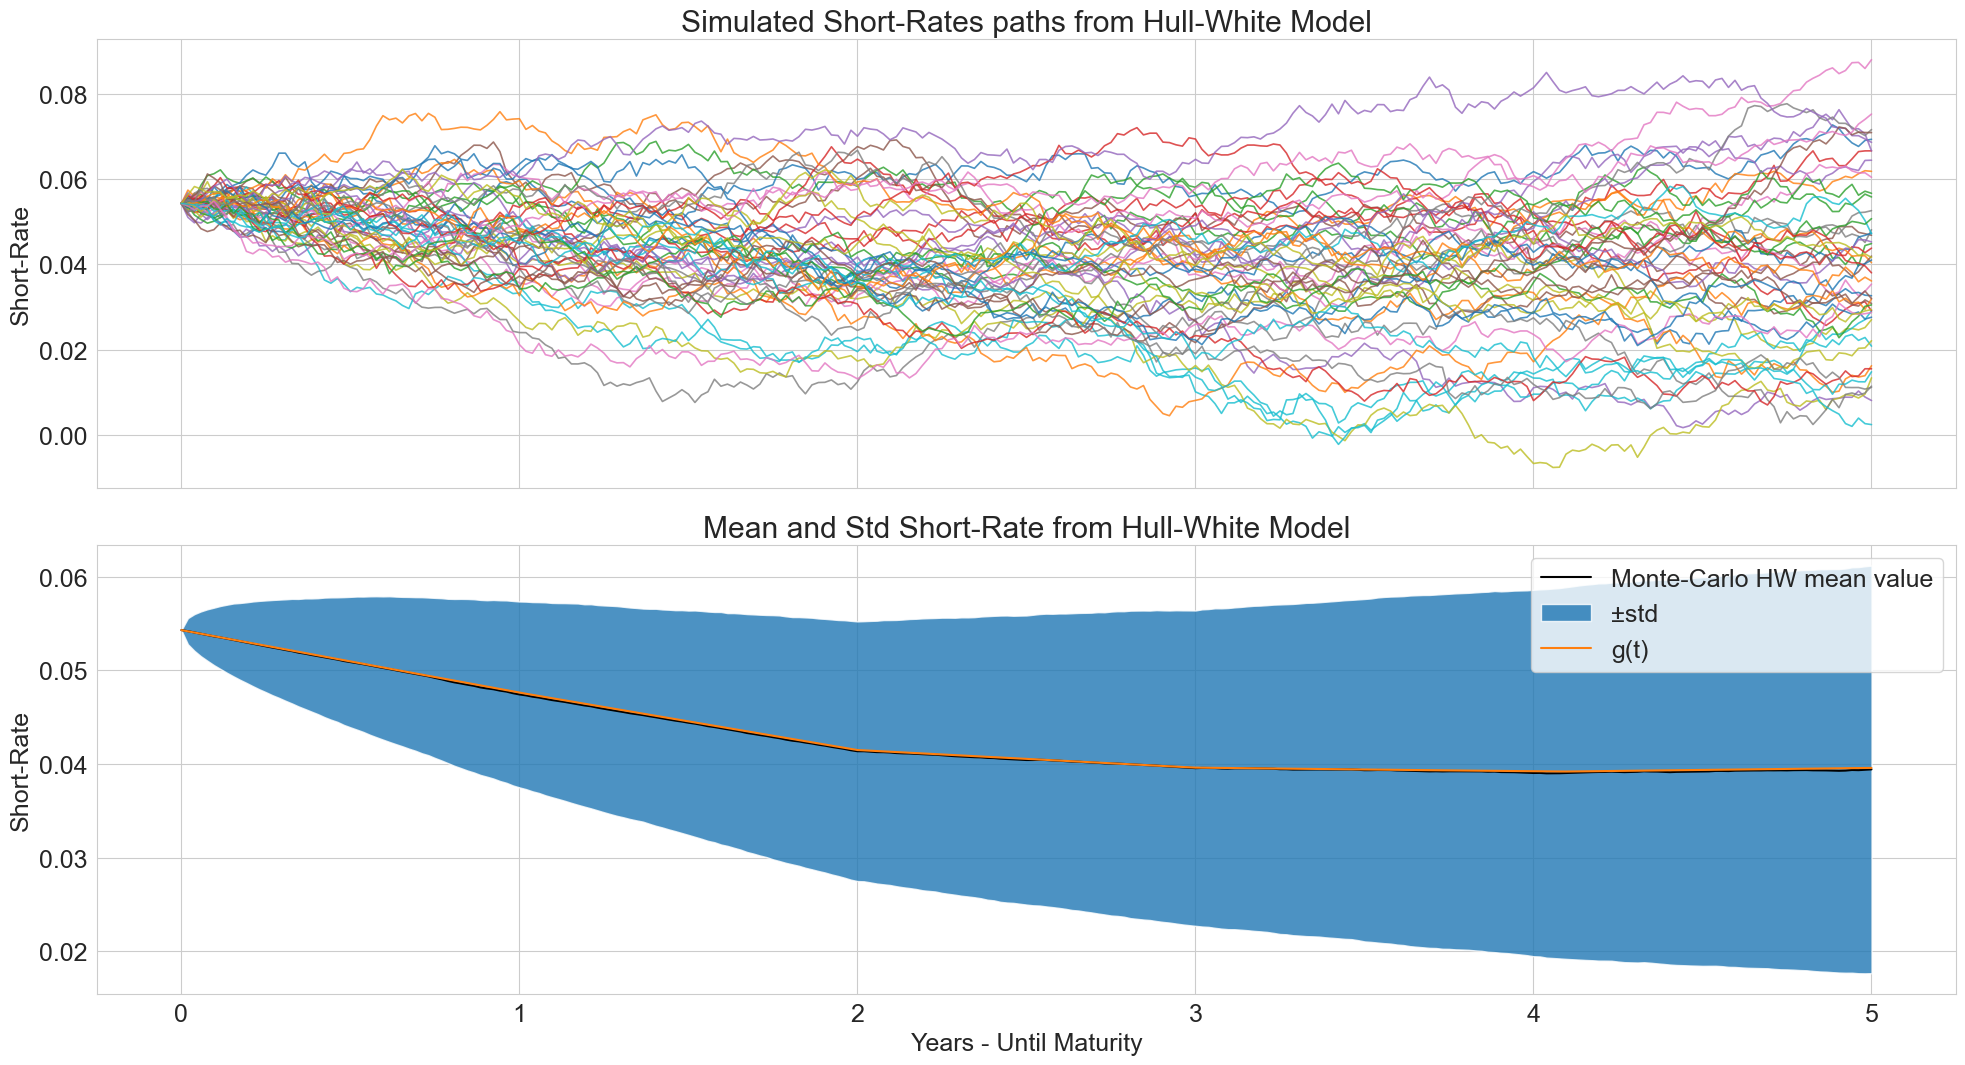

In [21]:
"""
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show MC generated short rate paths 
-> Play with paramteres of 'get_short_rate_HW' funciton to see how it affects the simulation 
"""
hw_r_t, g_t = CVA.get_short_rate_HW(T=plot_T, 
                                    a=scenarios[plot_scen]['mean_reversion'], 
                                    sigma=scenarios[plot_scen]['sigma'], 
                                    dt=dt, 
                                    paths=paths, 
                                    rates_df=df_SOFR3m_FallBack, 
                                    _print=True)

fig, axs = plt.subplots(2, sharex=True)
index = np.linspace(start=0, stop=plot_T, num=hw_r_t.T.shape[0], endpoint=True)
hv = pd.DataFrame(hw_r_t.T, index=index)
hv.sample(50, axis=1).plot(alpha=.8, lw=1.2, legend=False, title='Simulated Short-Rates paths from Hull-White Model', grid=True, ax=axs[0])
hv.mean(axis=1).plot(figsize=CHART_DIMENTIONS_DOUBLE_CHART,legend=False, title='Mean and Std Short-Rate from Hull-White Model', grid=True, ax=axs[1], color='black')
axs[1].fill_between(hv.index.values, hv.mean(axis=1)-hv.std(axis=1), hv.mean(axis=1)+hv.std(axis=1), alpha=.8)
axs[1].plot(index, g_t,'tab:orange')
axs[1].legend(['Monte-Carlo HW mean value', '±std', 'g(t)']) ; axs[1].set_xlabel('Years - Until Maturity') ; axs[1].set_ylabel('Short-Rate') ; axs[0].set_ylabel('Short-Rate')
gc.collect();print()

if SAVE_CHARTS: plt.savefig('Charts/2. Hull-White MC Paths.pdf')

a = 0.01, sigma = 0.02049051137173436, r_0 = 0.0543, T = 5
intervals: 260 
Total Points: 1300000
paths: 5000 
dt:  0.019230769230769232
hw.shape=(5000, 261), g_t.shape=(261,), t.shape=(261,)

>>Time to simulate: 0.586sec



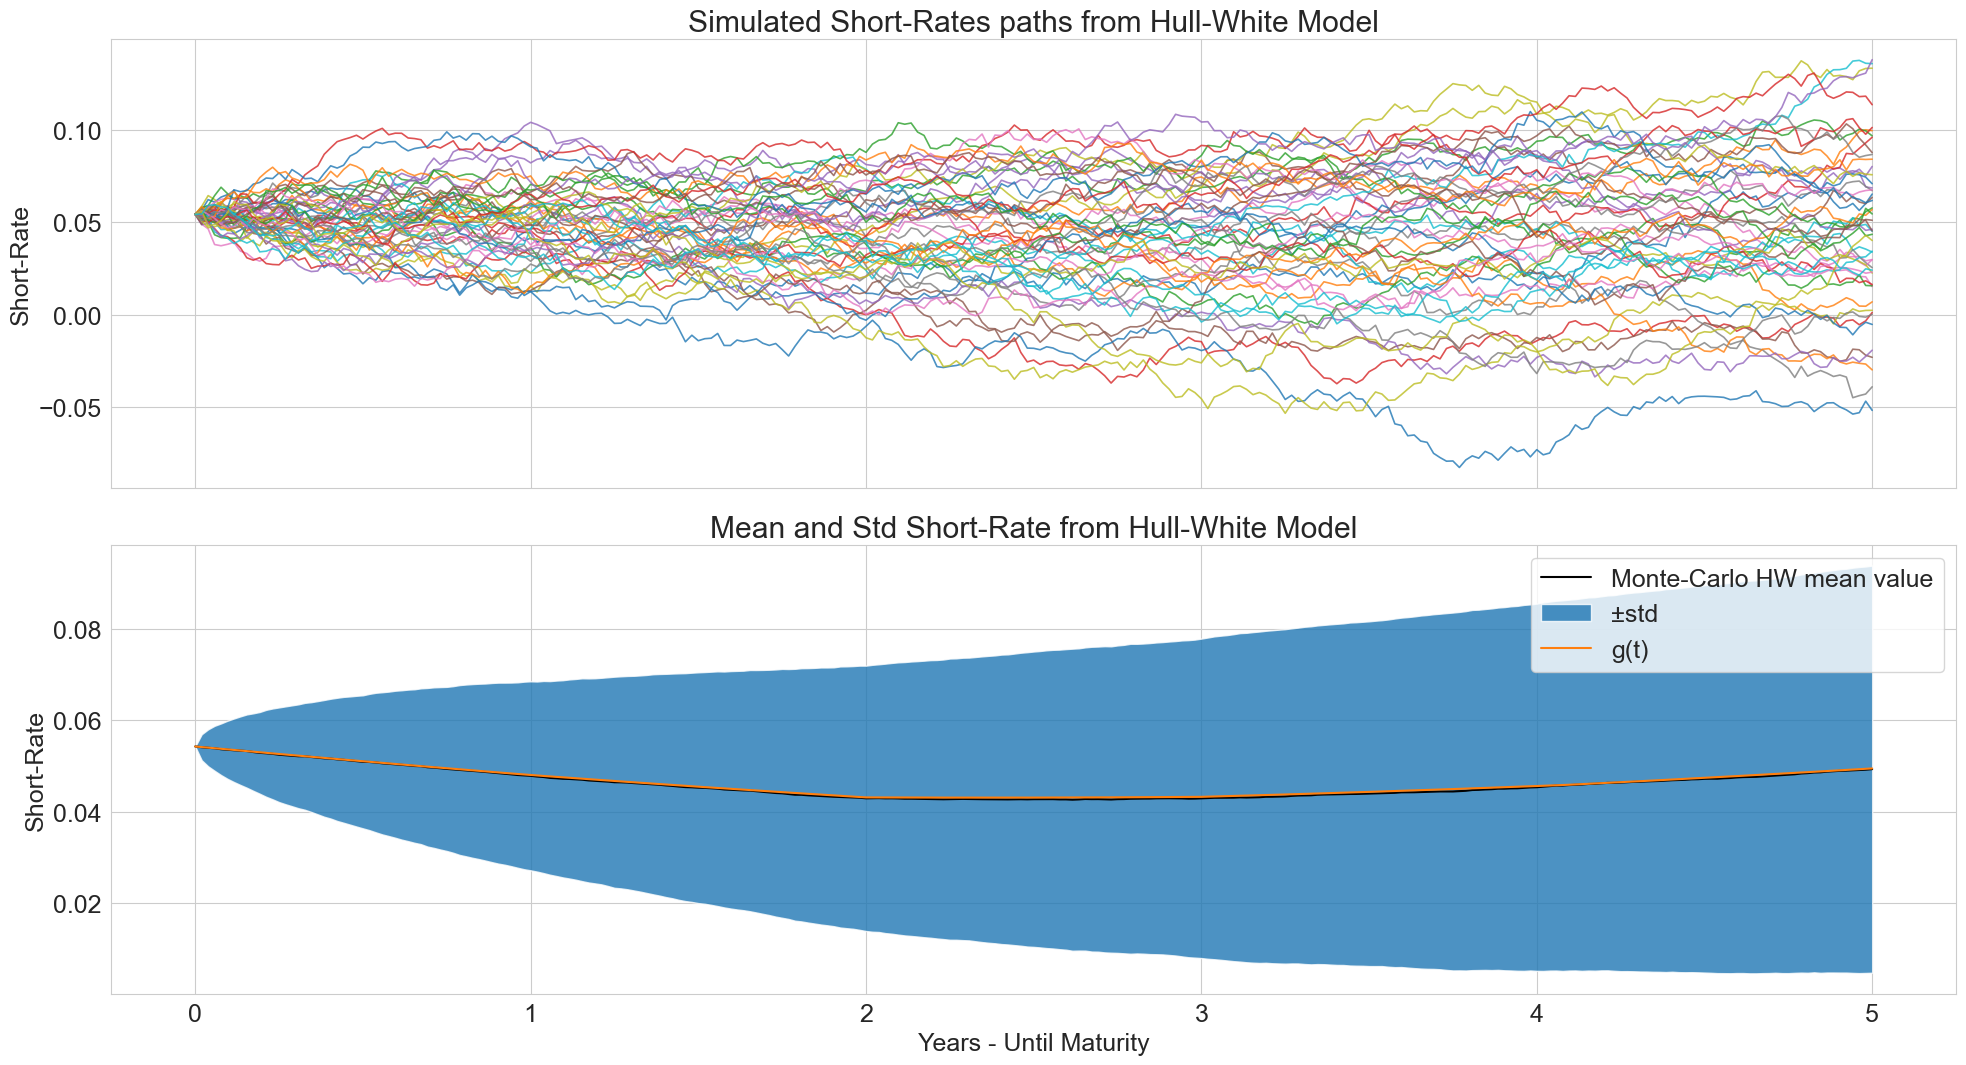

In [19]:
"""
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show MC generated short rate paths 
-> Play with paramteres of 'get_short_rate_HW' funciton to see how it affects the simulation 
"""
hw_r_t, g_t = CVA.get_short_rate_HW(T=plot_T, 
                                    a=scenarios[plot_scen]['mean_reversion'], 
                                    sigma=scenarios[plot_scen]['sigma'], 
                                    dt=dt, 
                                    paths=paths, 
                                    rates_df=df_SOFR3m_FallBack, 
                                    _print=True)

fig, axs = plt.subplots(2, sharex=True)
index = np.linspace(start=0, stop=plot_T, num=hw_r_t.T.shape[0], endpoint=True)
hv = pd.DataFrame(hw_r_t.T, index=index)
hv.sample(50, axis=1).plot(alpha=.8, lw=1.2, legend=False, title='Simulated Short-Rates paths from Hull-White Model', grid=True, ax=axs[0])
hv.mean(axis=1).plot(figsize=CHART_DIMENTIONS_DOUBLE_CHART,legend=False, title='Mean and Std Short-Rate from Hull-White Model', grid=True, ax=axs[1], color='black')
axs[1].fill_between(hv.index.values, hv.mean(axis=1)-hv.std(axis=1), hv.mean(axis=1)+hv.std(axis=1), alpha=.8)
axs[1].plot(index, g_t,'tab:orange')
axs[1].legend(['Monte-Carlo HW mean value', '±std', 'g(t)']) ; axs[1].set_xlabel('Years - Until Maturity') ; axs[1].set_ylabel('Short-Rate') ; axs[0].set_ylabel('Short-Rate')
gc.collect();print()

if SAVE_CHARTS: plt.savefig('Charts/2. Hull-White MC Paths.pdf')